In [1]:
!pip install xgboost
!pip install tensorflow
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, roc_auc_score


[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
df = pd.read_csv('ecommerce_2025.csv') 

In [3]:
df

,Order_Date,Time,Age,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Revenue,Shipping_Cost,Order_Priority,Payment_method,MKTG_Channel,Marketing_Spend
0,2018-01-02,10:56:33,36,37077,1,1,Member,Auto & Accessories,Car Media Players,140.0,4.6,Medium,credit_card,Email,16.10
1,2018-07-24,20:41:37,54,59173,1,1,Member,Auto & Accessories,Car Speakers,211.0,11.2,Medium,credit_card,Email,41.53
2,2018-11-08,08:38:49,32,41066,1,1,Member,Auto & Accessories,Car Body Covers,117.0,3.1,Critical,credit_card,Social,45.74
3,2018-04-18,19:28:06,43,50741,1,1,Member,Auto & Accessories,Car & Bike Care,118.0,2.6,High,credit_card,Paid Search,94.25
4,2018-08-13,21:18:39,48,53639,1,1,Member,Auto & Accessories,Tyre,250.0,16.0,Critical,credit_card,YouTube,34.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51278,2018-02-28,22:59:50,19,78489,1,0,Member,Home & Furniture,Shoe Rack,124.0,1.9,Medium,money_order,Paid Search,61.39
51279,2018-02-28,13:19:25,40,91941,1,0,Member,Home & Furniture,Umbrellas,70.0,1.4,Medium,credit_card,Email,22.62
51280,2018-02-28,10:25:07,24,63313,0,1,Member,Home & Furniture,Dinner Crockery,133.0,4.0,Medium,credit_card,Email,21.06
51281,2018-02-28,10:50:08,47,86485,0,1,Member,Home & Furniture,Sofa Covers,216.0,13.2,Medium,credit_card,Paid Search,62.12


In [4]:
#finding the last order date to use for recency calculatations
df['Order_Date'].max()


'2018-12-30'

In [5]:
df["Order_Date"] = pd.to_datetime(df["Order_Date"])

In [6]:
# Define churn: Customers with no purchases in the last 90 days (before 2018-12-30)
LAST_DATE = pd.Timestamp("2018-12-30")
df["Recency"] = (LAST_DATE - df["Order_Date"]).dt.days

# Compute customer tenure (days since first purchase)
first_purchase = df.groupby("Customer_Id")["Order_Date"].min().reset_index()

In [7]:
# joining first purchase to data frame 
# adding tenure to data frame
first_purchase.columns = ["Customer_Id", "First_Purchase_Date"]
df = df.merge(first_purchase, on="Customer_Id", how="left")
df["Tenure"] = (LAST_DATE - df["First_Purchase_Date"]).dt.days

In [8]:
# Define churn: If last purchase > 90 days ago
customer_last_purchase = df.groupby("Customer_Id")["Order_Date"].max().reset_index()
customer_last_purchase["Churn"] = ((LAST_DATE - customer_last_purchase["Order_Date"]).dt.days > 90).astype(int)
df = df.merge(customer_last_purchase[["Customer_Id", "Churn"]], on="Customer_Id", how="left")


In [9]:
df.columns

Index(['Order_Date', 'Time', 'Age', 'Customer_Id', 'Gender', 'Device_Type',
       'Customer_Login_type', 'Product_Category', 'Product', 'Revenue',
       'Shipping_Cost', 'Order_Priority', 'Payment_method', 'MKTG_Channel',
       'Marketing_Spend', 'Recency', 'First_Purchase_Date', 'Tenure', 'Churn'],
      dtype='object')

In [10]:
df

,Order_Date,Time,Age,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Revenue,Shipping_Cost,Order_Priority,Payment_method,MKTG_Channel,Marketing_Spend,Recency,First_Purchase_Date,Tenure,Churn
0,2018-01-02,10:56:33,36,37077,1,1,Member,Auto & Accessories,Car Media Players,140.0,4.6,Medium,credit_card,Email,16.10,362,2018-01-02,362,1
1,2018-07-24,20:41:37,54,59173,1,1,Member,Auto & Accessories,Car Speakers,211.0,11.2,Medium,credit_card,Email,41.53,159,2018-07-24,159,1
2,2018-11-08,08:38:49,32,41066,1,1,Member,Auto & Accessories,Car Body Covers,117.0,3.1,Critical,credit_card,Social,45.74,52,2018-11-08,52,0
3,2018-04-18,19:28:06,43,50741,1,1,Member,Auto & Accessories,Car & Bike Care,118.0,2.6,High,credit_card,Paid Search,94.25,256,2018-04-18,256,1
4,2018-08-13,21:18:39,48,53639,1,1,Member,Auto & Accessories,Tyre,250.0,16.0,Critical,credit_card,YouTube,34.08,139,2018-08-13,139,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51278,2018-02-28,22:59:50,19,78489,1,0,Member,Home & Furniture,Shoe Rack,124.0,1.9,Medium,money_order,Paid Search,61.39,305,2018-02-28,305,1
51279,2018-02-28,13:19:25,40,91941,1,0,Member,Home & Furniture,Umbrellas,70.0,1.4,Medium,credit_card,Email,22.62,305,2018-02-28,305,0
51280,2018-02-28,10:25:07,24,63313,0,1,Member,Home & Furniture,Dinner Crockery,133.0,4.0,Medium,credit_card,Email,21.06,305,2018-02-28,305,1
51281,2018-02-28,10:50:08,47,86485,0,1,Member,Home & Furniture,Sofa Covers,216.0,13.2,Medium,credit_card,Paid Search,62.12,305,2018-02-28,305,1


In [11]:
# Drop redundant columns
df.drop(columns=["Order_Date"], inplace=True)


In [12]:
# Encode categorical variables
categorical_cols = ["Gender", "Device_Type", "Customer_Login_type", "Product_Category",
                    "Order_Priority", "Payment_method", "MKTG_Channel"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [13]:
# Select features & target variable
features = ["Age", "Recency", "Tenure", "Revenue", "Shipping_Cost", "Marketing_Spend"] + \
           [col for col in df.columns if col.startswith(tuple(categorical_cols))]
X = df[features]
y = df["Churn"]

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Scale numerical features
scaler = StandardScaler()
X_train[["Age", "Recency", "Tenure", "Revenue", "Shipping_Cost", "Marketing_Spend"]] = scaler.fit_transform(
    X_train[["Age", "Recency", "Tenure", "Revenue", "Shipping_Cost", "Marketing_Spend"]])
X_test[["Age", "Recency", "Tenure", "Revenue", "Shipping_Cost", "Marketing_Spend"]] = scaler.transform(
    X_test[["Age", "Recency", "Tenure", "Revenue", "Shipping_Cost", "Marketing_Spend"]])


In [16]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}


In [17]:
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"{name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}, AUC: {roc_auc_score(y_test, y_prob):.4f}")


/Users/PKArthur/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.8059, AUC: 0.8482
Random Forest - Accuracy: 0.8776, AUC: 0.8568
XGBoost - Accuracy: 0.8752, AUC: 0.8548


/Users/PKArthur/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
# Neural Network Model
nn_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/PKArthur/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Train Neural Network
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
nn_loss, nn_acc = nn_model.evaluate(X_test, y_test, verbose=0)
y_prob_nn = nn_model.predict(X_test).flatten()
print(f"Neural Network - Accuracy: {nn_acc:.4f}, AUC: {roc_auc_score(y_test, y_prob_nn):.4f}")

Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step - accuracy: 0.8033 - loss: 0.4690
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.8773 - loss: 0.3337
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.8805 - loss: 0.3225
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.8834 - loss: 0.3166
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.8829 - loss: 0.3167
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.8862 - loss: 0.3111
Epoch 7/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.8868 - loss: 0.3086
Epoch 8/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.8851 - loss: 0.3116
Epoch 9/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.8870 - loss: 0.3085
Epoch 10/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.8861 - loss: 0.3101
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
Neural Network - Accuracy: 0.8735, AUC: 0.8600


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


In [30]:
# scores from the different models
model_scores = {
    "Logistic Regression": {"Accuracy": 0.805, "AUC": 0.848},
    "Random Forest": {"Accuracy": 0.877, "AUC": 0.856},
    "XGBoost": {"Accuracy": 0.875, "AUC": 0.854},
    "Neural Network": {"Accuracy": 0.873, "AUC": 0.860}
}


In [31]:
# Convert dictionary to DataFrame for easy plotting
df_scores = pd.DataFrame(model_scores).T.reset_index()
df_scores = df_scores.melt(id_vars="index", var_name="Metric", value_name="Score")
df_scores.sort_values(by='Score', ascending=False)

,index,Metric,Score
1,Random Forest,Accuracy,0.877
2,XGBoost,Accuracy,0.875
3,Neural Network,Accuracy,0.873
7,Neural Network,AUC,0.860
5,Random Forest,AUC,0.856
6,XGBoost,AUC,0.854
4,Logistic Regression,AUC,0.848
0,Logistic Regression,Accuracy,0.805


<Axes: xlabel='index', ylabel='Score'>

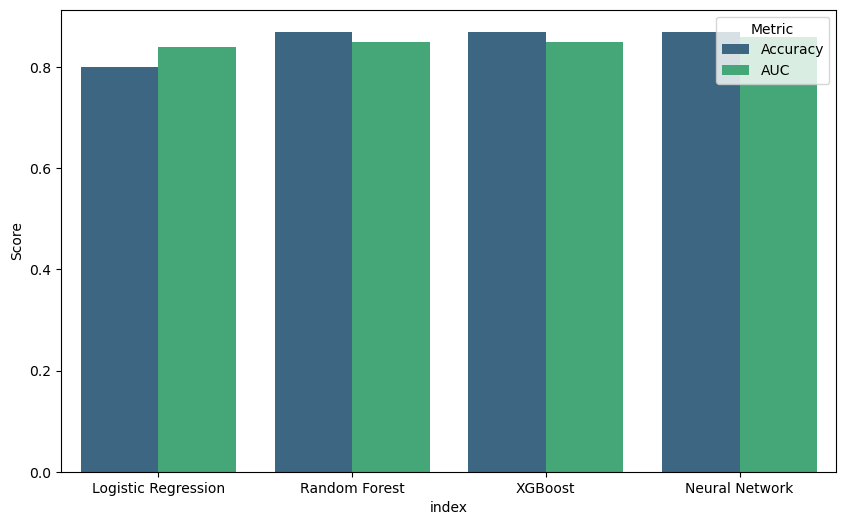

In [26]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=df_scores, x="index", y="Score", hue="Metric", palette="viridis")


# Model Performance Summary
The four models—Logistic Regression, Random Forest, XGBoost, and Neural Networks—were evaluated based on accuracy and AUC (Area Under the Curve).

Random Forest achieved the highest accuracy (0.877), closely followed by XGBoost (0.875) and Neural Networks (0.873). Logistic Regression had the lowest accuracy (0.805).
Neural Networks had the highest AUC (0.860), with Random Forest (0.856) and XGBoost (0.854) performing similarly. Logistic Regression had the lowest AUC (0.848).
While accuracy measures the proportion of correctly classified instances, AUC is a better metric for churn prediction because it evaluates how well the model distinguishes between churners and non-churners across different thresholds. Since churn is often an imbalanced problem, a high AUC means the model is better at ranking customers based on their likelihood to churn, making it more useful for prioritizing retention efforts.

Overall, Neural Networks had the best AUC, making it the strongest model for identifying churners, despite Random Forest having the highest accuracy.